In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')

import os
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from joblib import dump, load


In [48]:
### following function loads and reads the tab separated file, containing healthcare provider 
### data, as a pandas DataFrame

Provider_PATH = os.path.join('Medicare_Provider_Util_Payment_PUF_CY2017', 'Medicare_Provider_Util_Payment_PUF_CY2017.txt')


def load_provider_data(provider_path=Provider_PATH):
    provider_df = pd.read_csv(provider_path, "\t")
    return provider_df


In [49]:
### loading the dataset

provider_df = load_provider_data()

In [50]:
### loading convicted healthcare provider dataset

convicted_df = pd.read_csv('LEIE.csv')
convicted_df.head()

,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
0,NaN,NaN,,14 LAWRENCE AVE PHARMACY,PHARMACY,NaN,NaN,0,NaN,14 LAWRENCE AVENUE,SMITHTOWN,NY,11787,1128a1,19880830,0,0,NaN
1,NaN,NaN,,143 MEDICAL EQUIPMENT CO,DME COMPANY,DME - OXYGEN,NaN,0,NaN,701 NW 36 AVENUE,MIAMI,FL,33125,1128b7,19970620,0,0,NaN
2,NaN,NaN,,184TH STREET PHARMACY CORP,OTHER BUSINESS,PHARMACY,NaN,1922348218,NaN,69 E 184TH ST,BRONX,NY,10468,1128a1,20180419,0,0,NaN
3,NaN,NaN,,1951 FLATBUSH AVENUE PHARMACY,PHARMACY,NaN,NaN,0,NaN,1951 FLATBUSH AVE,BROOKLYN,NY,11234,1128b5,20090319,0,0,NaN
4,NaN,NaN,,"1ST COMMUNITY HEALTH CTR, LTD",CLINIC,NaN,NaN,0,NaN,3138 W CERMAK ROAD,CHICAGO,IL,60623,1128a1,19940524,0,0,NaN


In [51]:
convicted_df.shape

(72676, 18)

In [52]:
### A look at the available attributes

columns_provider = provider_df.columns 
columns_provider

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_mi', 'nppes_credentials', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_street1', 'nppes_provider_street2',
       'nppes_provider_city', 'nppes_provider_zip', 'nppes_provider_state',
       'nppes_provider_country', 'provider_type',
       'medicare_participation_indicator', 'place_of_service', 'hcpcs_code',
       'hcpcs_description', 'hcpcs_drug_indicator', 'line_srvc_cnt',
       'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_Medicare_allowed_amt',
       'average_submitted_chrg_amt', 'average_Medicare_payment_amt',
       'average_Medicare_standard_amt'],
      dtype='object')

### Searching for Missing values

In [53]:
pd.isnull(provider_df).any()

npi                                 False
nppes_provider_last_org_name         True
nppes_provider_first_name            True
nppes_provider_mi                    True
nppes_credentials                    True
nppes_provider_gender                True
nppes_entity_code                    True
nppes_provider_street1               True
nppes_provider_street2               True
nppes_provider_city                  True
nppes_provider_zip                   True
nppes_provider_state                 True
nppes_provider_country               True
provider_type                        True
medicare_participation_indicator     True
place_of_service                     True
hcpcs_code                           True
hcpcs_description                    True
hcpcs_drug_indicator                 True
line_srvc_cnt                        True
bene_unique_cnt                      True
bene_day_srvc_cnt                    True
average_Medicare_allowed_amt         True
average_submitted_chrg_amt        

In [54]:
pd.isnull(convicted_df).any()

LASTNAME       True
FIRSTNAME      True
MIDNAME       False
BUSNAME        True
GENERAL       False
SPECIALTY      True
UPIN           True
NPI           False
DOB            True
ADDRESS        True
CITY           True
STATE          True
ZIP           False
EXCLTYPE      False
EXCLDATE      False
REINDATE      False
WAIVERDATE    False
WVRSTATE       True
dtype: bool

In [55]:
provider_df = provider_df[1:]  ### dropping the first instance, in provider dataset, which is not an NPI

### Performing Dimensionality Reduction

In [56]:
### selecting the important attributes/features and dropping instances with missing values

selected_provider_data = provider_df[['npi', 'nppes_provider_gender', 'provider_type', 
                             'line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt',
                             'average_submitted_chrg_amt', 'average_Medicare_allowed_amt', 
                             'average_Medicare_payment_amt']].dropna(axis=0)


In [57]:
pd.isnull(selected_provider_data).any() ### confirming if there are any missing values

npi                             False
nppes_provider_gender           False
provider_type                   False
line_srvc_cnt                   False
bene_unique_cnt                 False
bene_day_srvc_cnt               False
average_submitted_chrg_amt      False
average_Medicare_allowed_amt    False
average_Medicare_payment_amt    False
dtype: bool

In [58]:
### A look at the features in convicted dataset

convicted_df.columns

Index(['LASTNAME', 'FIRSTNAME', 'MIDNAME', 'BUSNAME', 'GENERAL', 'SPECIALTY',
       'UPIN', 'NPI', 'DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE'],
      dtype='object')

NPI = National Provider Identifier

NPI is a unique identifier that has to be provided for each claim.

In [59]:
selected_convicted_data = convicted_df[['NPI']].dropna(axis=0)

pd.isnull(selected_convicted_data).any() ### confirming if there are any missing values in NPI feature

NPI    False
dtype: bool

### Joining the provider dataset with LEIE (convicted) labeled dataset 

In [60]:
merged_dataset = pd.merge(selected_provider_data, selected_convicted_data, 
                          how='right', left_on='npi', right_on='NPI').dropna(axis=0)

merged_dataset

,npi,nppes_provider_gender,provider_type,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_Medicare_allowed_amt,average_Medicare_payment_amt,NPI
0,1.003128e+09,M,Internal Medicine,617.0,499.0,617.0,332.463533,219.944716,170.918590,1003127655
1,1.003128e+09,M,Internal Medicine,249.0,17.0,249.0,69.899598,42.570080,33.024418,1003127655
2,1.003128e+09,M,Internal Medicine,1220.0,235.0,1220.0,120.000000,78.414213,61.340197,1003127655
3,1.003128e+09,M,Internal Medicine,754.0,434.0,754.0,172.590186,113.284987,88.611313,1003127655
4,1.003128e+09,M,Internal Medicine,543.0,448.0,543.0,188.176796,117.852320,91.907495,1003127655
...,...,...,...,...,...,...,...,...,...,...
1810,1.982676e+09,M,Emergency Medicine,265.0,67.0,265.0,125.000000,67.717925,43.902528,1982676136
1811,1.982676e+09,M,Emergency Medicine,24.0,24.0,24.0,165.000000,102.440000,34.667917,1982676136
1812,1.992768e+09,M,Family Practice,29.0,27.0,29.0,574.000000,65.900000,49.888276,1992768477
1813,1.992768e+09,M,Family Practice,32.0,32.0,32.0,757.000000,125.010000,92.168750,1992768477


### Plotting different features to see if there is any kind of correlation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fbcf780>,
      dtype=object)

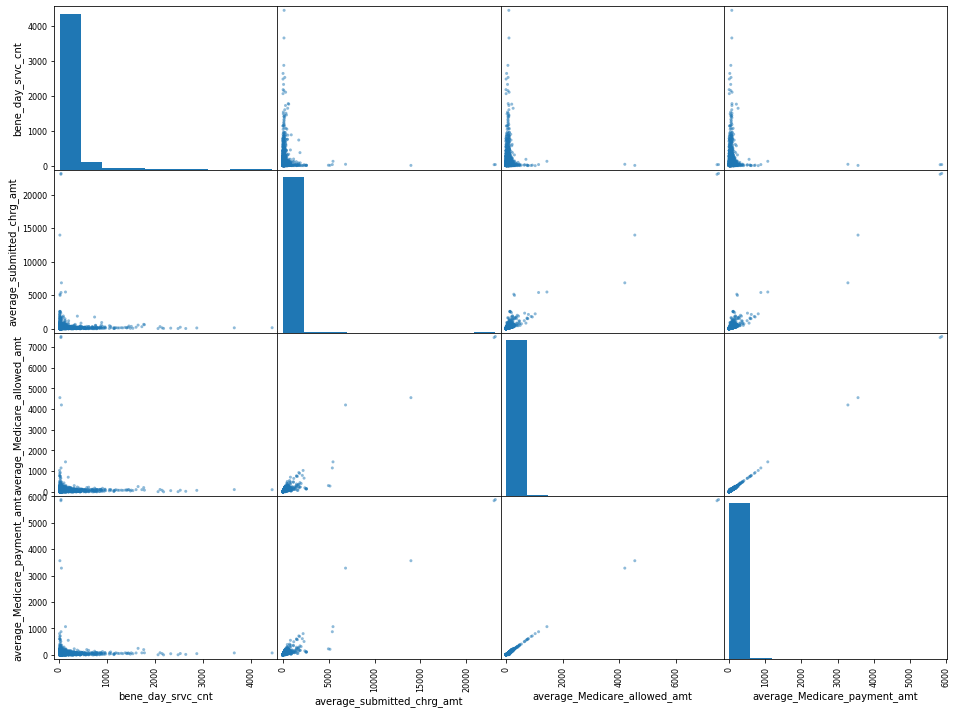

In [61]:
%matplotlib inline

from pandas.plotting import scatter_matrix

attributes = ["bene_day_srvc_cnt", "average_submitted_chrg_amt",
              "average_Medicare_allowed_amt", "average_Medicare_payment_amt"]


scatter_matrix(merged_dataset[attributes], figsize=(16, 12))


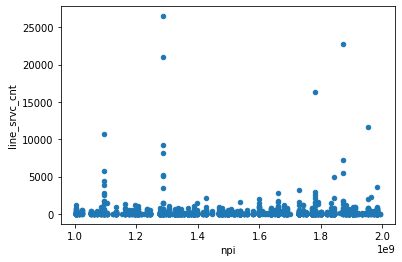

In [62]:
merged_dataset.plot(kind='scatter', x='npi', y='line_srvc_cnt')

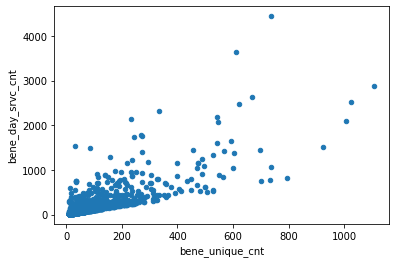

In [63]:
merged_dataset.plot(kind='scatter', x='bene_unique_cnt', y='bene_day_srvc_cnt')

In [64]:
# calculating the number of unique service providers in merged_dataset

merged_dataset.nunique()

npi                              190
nppes_provider_gender              2
provider_type                     39
line_srvc_cnt                    471
bene_unique_cnt                  282
bene_day_srvc_cnt                425
average_submitted_chrg_amt      1026
average_Medicare_allowed_amt    1589
average_Medicare_payment_amt    1749
NPI                              190
dtype: int64

### A look at the gender ratio in different datasets

In [65]:
print(merged_dataset['nppes_provider_gender'].describe())

print(provider_df['nppes_provider_gender'].describe())

count     1815
unique       2
top          M
freq      1724
Name: nppes_provider_gender, dtype: object
count     9416125
unique          2
top             M
freq      6535107
Name: nppes_provider_gender, dtype: object


In [66]:
print(1724/1815) ### percentage of males in excluded/convicted dataset

print(6535107/9416125) ### percentage of males in provider dataset

0.949862258953168
0.6940335860027347


In [67]:
### a peek at the merged dataset

print(merged_dataset.columns)

Index(['npi', 'nppes_provider_gender', 'provider_type', 'line_srvc_cnt',
       'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_submitted_chrg_amt',
       'average_Medicare_allowed_amt', 'average_Medicare_payment_amt', 'NPI'],
      dtype='object')


In [68]:
### to see if there are any differences in the NPI values in merged dataset

comparison = merged_dataset['npi'] == merged_dataset['NPI']

comparison.nunique()

1

Since they are the same, we can drop one of these two columns. 

In [69]:
merged_dataset = merged_dataset.drop('NPI', axis=1)
merged_dataset.head(10)

,npi,nppes_provider_gender,provider_type,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_Medicare_allowed_amt,average_Medicare_payment_amt
0,1.003128e+09,M,Internal Medicine,617.0,499.0,617.0,332.463533,219.944716,170.918590
1,1.003128e+09,M,Internal Medicine,249.0,17.0,249.0,69.899598,42.570080,33.024418
2,1.003128e+09,M,Internal Medicine,1220.0,235.0,1220.0,120.000000,78.414213,61.340197
3,1.003128e+09,M,Internal Medicine,754.0,434.0,754.0,172.590186,113.284987,88.611313
4,1.003128e+09,M,Internal Medicine,543.0,448.0,543.0,188.176796,117.852320,91.907495
5,1.003128e+09,M,Internal Medicine,414.0,316.0,414.0,273.828502,181.887440,139.755266
6,1.003128e+09,M,Internal Medicine,658.0,218.0,658.0,141.793313,100.259909,77.022340
7,1.003128e+09,M,Internal Medicine,52.0,51.0,52.0,90.000000,60.180000,47.180000
8,1.003811e+09,M,Pain Management,90.0,32.0,90.0,105.000000,84.290000,53.103444
9,1.003811e+09,M,Pain Management,126.0,46.0,126.0,130.000000,123.460000,83.113968


In [70]:
merged_dataset.shape

(1815, 9)

### Fraud and non-fraud labels

One extra feature needs to be created to label the npi as numerical attributes of fraudulent and non-fraudulent. 

### Adding a feature for fraud labeling

In [71]:
merged_dataset['label'] = 1

### Fraud and non-fraud labels added to provider dataset

In [72]:
labeled_final = pd.merge(selected_provider_data, merged_dataset[['npi', 'label']], 
                        how='left', on='npi').fillna(0)


In [73]:
labeled_final.head()

,npi,nppes_provider_gender,provider_type,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_Medicare_allowed_amt,average_Medicare_payment_amt,label
0,1003000126,M,Internal Medicine,100.0,96.0,100.0,325.780000,73.398800,56.827200,0.0
1,1003000126,M,Internal Medicine,26.0,25.0,26.0,449.000000,100.080000,78.460000,0.0
2,1003000126,M,Internal Medicine,52.0,51.0,52.0,614.000000,136.380000,102.807692,0.0
3,1003000126,M,Internal Medicine,59.0,59.0,59.0,755.932203,190.363729,141.293559,0.0
4,1003000126,M,Internal Medicine,16.0,16.0,16.0,462.812500,101.680000,79.710000,0.0


In [74]:
labeled_final.shape

(9449787, 10)

In [75]:
labeled_final['label'].sum()

35469.0

In [76]:
labeled_final.dtypes

npi                               int64
nppes_provider_gender            object
provider_type                    object
line_srvc_cnt                   float64
bene_unique_cnt                 float64
bene_day_srvc_cnt               float64
average_submitted_chrg_amt      float64
average_Medicare_allowed_amt    float64
average_Medicare_payment_amt    float64
label                           float64
dtype: object

### Splitting the data into train and test datasets

In [77]:
X_train, X_test, y_train, y_test = train_test_split(labeled_final[['npi', 'nppes_provider_gender', 'provider_type', 
                                   'line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt', 
                                   'average_submitted_chrg_amt','average_Medicare_allowed_amt',
                                   'average_Medicare_payment_amt']], labeled_final['label'],
                                    random_state=42)
 
    


In [78]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (7087340, 9)
y_train shape: (7087340,)


In [79]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (2362447, 9)
y_test shape: (2362447,)


### Removing npi feature as it is not required in training the model

In [80]:
X_train = X_train.iloc[:, 1:]

In [81]:
X_train.head()

,nppes_provider_gender,provider_type,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_Medicare_allowed_amt,average_Medicare_payment_amt
6922930,M,Gastroenterology,111.0,111.0,111.0,1510.955676,251.515405,189.624685
2347898,M,Internal Medicine,70.0,69.0,70.0,1433.380000,206.650000,158.753571
3767506,F,Family Practice,42.0,42.0,42.0,175.000000,114.290000,112.000000
2451995,F,Nurse Practitioner,257.0,41.0,257.0,120.000000,94.640000,74.200000
21627,F,Family Practice,136.0,77.0,136.0,135.000000,78.818235,49.446397


### Selecting categorical features

In [82]:
cat_features = labeled_final.select_dtypes(include=[object])

cat_features.head()

,nppes_provider_gender,provider_type
0,M,Internal Medicine
1,M,Internal Medicine
2,M,Internal Medicine
3,M,Internal Medicine
4,M,Internal Medicine


In [83]:
### To see how many unique provider types are there

X_train['provider_type'].nunique()

88

### ColumnTransformer Pipeline is applied to convert categorical features into numerical ones

ColumnTransformer to process selective features only.

In [84]:
# use when different features need different preprocessing
from sklearn.compose import make_column_transformer

# column_transformer pipeline to apply OneHotEncoder on cat features only
column_trans = make_column_transformer(
    (OneHotEncoder(sparse=False), ['nppes_provider_gender', 'provider_type']),
    remainder='passthrough')

X_train = column_trans.fit_transform(X_train)

In [85]:
X_train.shape

(7087340, 96)

In [86]:
type(X_train)

numpy.ndarray

### Converting sparse matrix/ndarray back to DataFrame

In [87]:
X_train = pd.DataFrame(X_train)

print(X_train.shape)

(7087340, 96)


Finally, the dataset is ready for the model. Hurray...

### Creating a pipeline for future applications

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_reg = LogisticRegression()

pipe = (column_trans, log_reg)

In [89]:
# cross-validate the entire process
# thus, preprocessing occurs within each fold of cross-validation

from sklearn.linear_model import LogisticRegressionCV

lr_cv = LogisticRegressionCV(cv=5, random_state=42)
lr_cv_fitting = lr_cv.fit(X_train, y_train)

### Model persistence using joblib

In [90]:
import joblib

joblib.dump(lr_cv_fitting, "lr_cv_fitting.pkl")



['lr_cv_fitting.pkl']

### Testing the Model using Test Data

In [91]:
X_test = X_test.iloc[:, 1:] ### dropping npi feature

In [92]:
### column_transformer pipeline applied on test data
X_test = column_trans.transform(X_test)

In [93]:
X_test = pd.DataFrame(X_test) ### Converting X_test to dataframe

In [94]:
X_test.shape

(2362447, 96)

To make sure that X_test has same number of features after OHE as X_train, an inner join is performed.

X_train_final, X_test_final = X_train.align(X_test, join='inner', axis=1)  # inner join

In [95]:
### loading the dumped model
lr_cv_loaded = joblib.load("lr_cv_fitting.pkl")

### applying the model to predict on test data

y_predicted_lrcv = lr_cv_loaded.predict(X_test)

### Evaluating the model using multiple metrics

### Accuracy score

In [97]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_predicted_lrcv))

0.99625515408388


### Classification report

In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted_lrcv))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2353603
         1.0       0.00      0.00      0.00      8844

    accuracy                           1.00   2362447
   macro avg       0.50      0.50      0.50   2362447
weighted avg       0.99      1.00      0.99   2362447



### Probability of predicting y

In [99]:
y_predicted_prob_lrcv = lr_cv_loaded.predict_proba(X_test)[:, 1]

### ROC Curve

In [100]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_predicted_prob_lrcv)

### Plotting ROC Curve

No handles with labels found to put in legend.


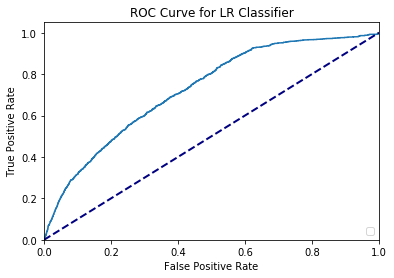

In [101]:
plt.figure()
lw_1 = 2
plt.plot(fpr_lr, tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw_1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LR Classifier')
plt.legend(loc="lower right")
plt.show()

### AUC

In [102]:
from sklearn.metrics import roc_auc_score

auc_score_lrcv = roc_auc_score(y_test, y_predicted_prob_lrcv)
print("\n\n AUC score for LR Classifier: ",auc_score_lrcv)



 AUC score for LR Classifier:  0.7252385291187126


### Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(max_depth=2, random_state=42)

#clf.fit(X_train, y_train)



### cross-validate the entire process
### thus, preprocessing occurs within each fold of cross-validation
# cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean()


rfc_fitting = rfc.fit(X_train, y_train)

### Model Persistence

In [104]:
dump(rfc_fitting, "rfc_fitting.pkl")

['rfc_fitting.pkl']

In [105]:
rfc_loaded = load("rfc_fitting.pkl")

Accuracy of RF: 0.9962564239536379 


Classification Report of RF: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2353603
         1.0       0.00      0.00      0.00      8844

    accuracy                           1.00   2362447
   macro avg       0.50      0.50      0.50   2362447
weighted avg       0.99      1.00      0.99   2362447
 




No handles with labels found to put in legend.


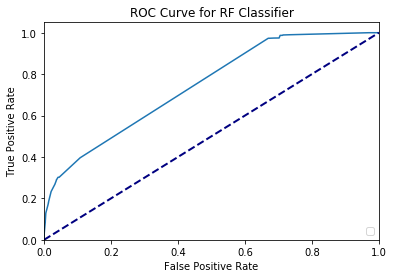



 AUC score for RF Classifier:  0.7443862199985568


In [106]:
### applying the model on test data
y_predicted_rfc = rfc_loaded.predict(X_test)

### accuracy of rfc
print("Accuracy of RF:", metrics.accuracy_score(y_test, y_predicted_rfc),"\n\n")

### classification report
print("Classification Report of RF: \n", classification_report(y_test, y_predicted_rfc), "\n\n")

### probability of predicting correct y
y_predicted_prob_rfc = rfc_loaded.predict_proba(X_test)[:, 1]

### ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_predicted_prob_rfc)

### plotting ROC curve
plt.figure()
lw_1 = 2
plt.plot(fpr_rf, tpr_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw_1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF Classifier')
plt.legend(loc="lower right")
plt.show()

### AUC score
auc_score_rfc = roc_auc_score(y_test, y_predicted_prob_rfc)
print("\n\n AUC score for RF Classifier: ",auc_score_rfc)

### Gradient Boosted Trees

In [107]:
from sklearn import ensemble

### Fit regression model
params = {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.1}
clf_gbt = ensemble.GradientBoostingClassifier(**params)

gbtc = clf_gbt.fit(X_train, y_train)

In [108]:
dump(gbtc, "gbtc_fitting.pkl")

['gbtc_fitting.pkl']

In [109]:
gbtc_loaded = load("gbtc_fitting.pkl")

Accuracy of GBT: 0.9962742021302489 


Classification Report of GBT:                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2353603
         1.0       0.92      0.01      0.01      8844

    accuracy                           1.00   2362447
   macro avg       0.96      0.50      0.50   2362447
weighted avg       1.00      1.00      0.99   2362447
 




No handles with labels found to put in legend.


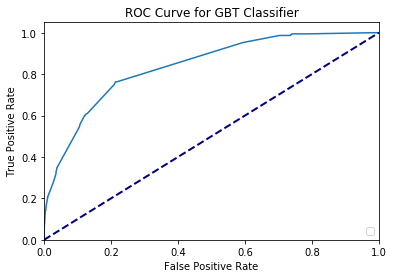



 AUC score for GBT Classifier:  0.8379454987952492


In [110]:
### applying the model on test data
y_predicted_gbtc = gbtc_loaded.predict(X_test)

### accuracy of gbtc
print("Accuracy of GBT:", metrics.accuracy_score(y_test, y_predicted_gbtc),"\n\n")

### classification report
print("Classification Report of GBT: ", classification_report(y_test, y_predicted_gbtc), "\n\n")

### probability of predicting correct y
y_predicted_prob_gbtc = gbtc_loaded.predict_proba(X_test)[:, 1]

### ROC Curve
fpr_gbt, tpr_gbt, thresholds_gbt = roc_curve(y_test, y_predicted_prob_gbtc)

### plotting ROC curve
plt.figure()
lw_1 = 2
plt.plot(fpr_gbt, tpr_gbt)
plt.plot([0, 1], [0, 1], color='navy', lw=lw_1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBT Classifier')
plt.legend(loc="lower right")
plt.show()

### AUC score
auc_score_gbtc = roc_auc_score(y_test, y_predicted_prob_gbtc)
print("\n\n AUC score for GBT Classifier: ",auc_score_gbtc)

In [165]:
print("\n AUC score for LR Classifier: ",auc_score_lrcv,
      "\n\n AUC score for RF Classifier: ",auc_score_rfc,
      "\n\n AUC score for GBT Classifier: ",auc_score_gbtc, "\n\n")


 AUC score for LR Classifier:  0.7252385291187126 

 AUC score for RF Classifier:  0.7443862199985568 

 AUC score for GBT Classifier:  0.8379454987952492 




### Statistical Signifance of model differences

In [111]:
import researchpy as rp
import statsmodels.api as sm
import statsmodels.stats.multicomp


In [151]:
### Seeing if the overall model is significant

model_lr = sm.OLS(y_predicted_prob_lrcv, y_test)

results_lr = model_lr.fit()
print(results_lr.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                          1.390e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                        0.00
Time:                        20:46:23   Log-Likelihood:                      8.4101e+06
No. Observations:             2362447   AIC:                                 -1.682e+07
Df Residuals:                 2362446   BIC:                                 -1.682e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
anova_lr = sm.stats.anova_lm(results_lr, typ= 2)

In [150]:
### RF
model_rf = sm.OLS(y_predicted_prob_rfc, y_test)
results_rf = model_rf.fit()
print(results_rf.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                          2.607e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                        0.00
Time:                        20:46:11   Log-Likelihood:                      9.5797e+06
No. Observations:             2362447   AIC:                                 -1.916e+07
Df Residuals:                 2362446   BIC:                                 -1.916e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [152]:
### GBT
model_gbt = sm.OLS(y_predicted_prob_gbtc, y_test)
results_gbt = model_gbt.fit()
print(results_gbt.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                          8.214e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                        0.00
Time:                        20:46:34   Log-Likelihood:                      7.8343e+06
No. Observations:             2362447   AIC:                                 -1.567e+07
Df Residuals:                 2362446   BIC:                                 -1.567e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [162]:
anova_results = sm.stats.anova_lm(results_lr,results_rf, results_gbt, typ= 1)

In [149]:
mc = statsmodels.stats.multicomp.MultiComparison(y_predicted_lrcv, y_predicted_gbtc)
mc_results = mc.tukeyhsd()
print(mc_results)


0.0